In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from mixup import *

class Attention(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, groups=1,
                 reduction = 0.0625, kernel_num=4, min_channel=16,
                 temperature = 60.0):

        super(Attention, self).__init__()
        attention_channel = max(int(in_planes * reduction), min_channel)
        self.kernel_size = kernel_size
        self.kernel_num = kernel_num
        self.temperature = temperature

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Conv2d(in_planes, attention_channel, 1, bias=False)
        self.bn = nn.BatchNorm2d(attention_channel)
        self.relu = nn.ReLU(inplace=True)

        self.channel_fc = nn.Conv2d(attention_channel, in_planes, 1, bias=True)
        self.func_channel = self.get_channel_attention

        if in_planes == groups and in_planes == out_planes:  # depth-wise convolution
            self.func_filter = self.skip
        else:
            self.filter_fc = nn.Conv2d(attention_channel, out_planes,
                                       1, bias=True)
            self.func_filter = self.get_filter_attention

        if kernel_size == 1:  # point-wise convolution
            self.func_spatial = self.skip
        else:
            self.spatial_fc = nn.Conv2d(attention_channel, kernel_size * kernel_size,
                                        1, bias=True)
            self.func_spatial = self.get_spatial_attention

        if kernel_num == 1:
            self.func_kernel = self.skip
        else:
            self.kernel_fc = nn.Conv2d(attention_channel, kernel_num,
                                       1, bias=True)
            self.func_kernel = self.get_kernel_attention

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def update_temperature(self, temperature):
        self.temperature = temperature

    @staticmethod
    def skip(_):
        return 1.0

    def get_channel_attention(self, x):
        channel_attention = torch.sigmoid(self.channel_fc(x).view(x.size(0), -1, 1, 1) / self.temperature)
        return channel_attention

    def get_filter_attention(self, x):
        filter_attention = torch.sigmoid(self.filter_fc(x).view(x.size(0), -1, 1, 1) / self.temperature)
        return filter_attention

    def get_spatial_attention(self, x):
        spatial_attention = self.spatial_fc(x).view(x.size(0), 1, 1, 1, self.kernel_size, self.kernel_size)
        spatial_attention = torch.sigmoid(spatial_attention / self.temperature)
        return spatial_attention

    def get_kernel_attention(self, x):
        kernel_attention = self.kernel_fc(x).view(x.size(0), -1, 1, 1, 1, 1)
        kernel_attention = F.softmax(kernel_attention / self.temperature, dim=1)
        return kernel_attention

    def forward(self, x):
        x = self.avgpool(x)
        x = self.fc(x)
        x = self.bn(x)
        x = self.relu(x)
        return self.func_channel(x), self.func_filter(x), self.func_spatial(x), self.func_kernel(x)


class ODConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1,
                 reduction = 0.0625, kernel_num=4,
                 temperature = 60.0):
        super(ODConv2d, self).__init__()
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.kernel_num = kernel_num
        self.attention = Attention(in_planes, out_planes,
                                   kernel_size, groups=groups,
                                   reduction=reduction,
                                   kernel_num=kernel_num,
                                   temperature = temperature)
        self.weight = nn.Parameter(torch.randn(kernel_num, out_planes,
                                               in_planes//groups, kernel_size, kernel_size),
                                   requires_grad=True)
        self._initialize_weights()

        if self.kernel_size == 1 and self.kernel_num == 1:
            self._forward_impl = self._forward_impl_pw1x
        else:
            self._forward_impl = self._forward_impl_common

    def _initialize_weights(self):
        for i in range(self.kernel_num):
            nn.init.kaiming_normal_(self.weight[i], mode='fan_out', nonlinearity='relu')

    def update_temperature(self, temperature):
        self.attention.update_temperature(temperature)

    def get_temperature(self):
        return self.attention.temperature

    def _forward_impl_common(self, x):
        # Multiplying channel attention (or filter attention) to weights and feature maps are equivalent,
        # while we observe that when using the latter method the models will run faster with less gpu memory cost.
        channel_attention, filter_attention,  \
            spatial_attention, kernel_attention = self.attention(x)

        batch_size, in_planes, height, width = x.size()
        x = x * channel_attention
        x = x.reshape(1, -1, height, width)
        aggregate_weight = spatial_attention * kernel_attention * \
                         self.weight.unsqueeze(dim=0)
        aggregate_weight = torch.sum(aggregate_weight, dim=1).view(
            [-1, self.in_planes // self.groups, self.kernel_size, self.kernel_size])
        output = F.conv2d(x, weight = aggregate_weight, bias = None,
                          stride = self.stride, padding = self.padding,
                          dilation = self.dilation,
                          groups = self.groups * batch_size)
        output = output.view(batch_size, self.out_planes,
                             output.size(-2), output.size(-1))
        output = output * filter_attention
        return output

    def _forward_impl_pw1x(self, x):
        channel_attention, filter_attention, \
            spatial_attention, kernel_attention = self.attention(x)
        x = x * channel_attention
        output = F.conv2d(x, weight=self.weight.squeeze(dim=0),
                          bias=None, stride=self.stride, padding=self.padding,
                          dilation=self.dilation, groups=self.groups)
        output = output * filter_attention
        return output

    def forward(self, x):
        return self._forward_impl(x)


class ODConvBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1,
                 groups=1, norm_layer=nn.BatchNorm2d,
                 reduction=0.0625, kernel_num = 1, temperature = 60.0):
        padding = (kernel_size - 1) // 2
        super(ODConvBN, self).__init__(
            ODConv2d(in_planes, out_planes, kernel_size,
                     stride, padding, groups = groups,
                     reduction = reduction,
                     kernel_num = kernel_num, temperature = temperature),
            norm_layer(out_planes)
        )

In [2]:
"""
Creates a MobileNetV3 Model as defined in:
Andrew Howard, Mark Sandler, Grace Chu, Liang-Chieh Chen, Bo Chen, Mingxing Tan, Weijun Wang, Yukun Zhu, Ruoming Pang, Vijay Vasudevan, Quoc V. Le, Hartwig Adam. (2019).
Searching for MobileNetV3
arXiv preprint arXiv:1905.02244.
"""

import torch.nn as nn
import math


__all__ = ['mobilenetv3_large', 'mobilenetv3_small']


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y




In [3]:
def conv_3x3(inp, oup, stride, batch_norm = True):
    layers = [
        nn.Conv2d(inp, oup, kernel_size=3, stride=1,
                  padding=1, bias=False),
        h_swish()
    ]#
    if batch_norm:
        layers.insert(1, nn.BatchNorm2d(oup))

    return nn.Sequential(*layers)

def conv_1x1(inp, oup, batch_norm = True):
    layers = [
        nn.Conv2d(inp, oup, kernel_size=1, stride=1,
                  padding=0, bias=False),
        h_swish()
    ]
    if batch_norm:
        layers.insert(1, nn.BatchNorm2d(oup))

    return nn.Sequential(*layers)

In [4]:
def od_conv_1x1(inp, oup, stride = 1, kernel_num = 4,
                temperature = 60,
                batch_norm = True):
    return nn.Sequential(
        ODConvBN(inp, oup, kernel_size = 1, stride = stride,
            kernel_num = kernel_num, temperature = temperature) \
                if batch_norm == True else \
        ODConv2d(inp, oup, kernel_size = 1, stride = stride,
            kernel_num = kernel_num, temperature = temperature),

        h_swish()
    )

def od_conv_3x3(inp, oup, stride = 1,
                kernel_num = 4, temperature = 60,
                batch_norm = True):
    return nn.Sequential(
         ODConvBN(inp, oup, kernel_size = 3, stride = stride,
            kernel_num = kernel_num, temperature = temperature) \
                if batch_norm == True else \
        ODConv2d(inp, oup, kernel_size = 3, stride = stride,
            kernel_num = kernel_num, temperature = temperature),

        h_swish()
    )

In [5]:
class InvertedResidualOD(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size,
                 stride, use_se, use_hs,
                 kernel_num_1 = 4,
                 kernel_num_2 = 4, temperature = 60.0):
        super(InvertedResidualOD, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup
        print("Using OmniDimensional")
        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                ODConvBN(hidden_dim, hidden_dim, kernel_size, stride,
                         groups=hidden_dim, kernel_num = kernel_num_1,
                         temperature = temperature),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                ODConv2d(hidden_dim, oup, 1, 1, kernel_num = kernel_num_2,
                         temperature = temperature),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                ODConvBN(inp, hidden_dim, kernel_size = 1, stride = 1,
                         kernel_num = kernel_num_2, temperature = temperature),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                ODConvBN(hidden_dim, hidden_dim, kernel_size,
                         stride, groups=hidden_dim, kernel_num = kernel_num_1,
                         temperature = temperature),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                ODConv2d(hidden_dim, oup, 1, 1, kernel_num = kernel_num_2,
                         temperature = temperature),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


In [6]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        print("Using Normal")
        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


In [7]:
class MobileNetV3(nn.Module):
    def __init__(self, cfgs, mode, kernel_num_1, kernel_num_2,
                 temperature, od_bottleneck = 0, 
                 od_outside = 0, num_classes = 10, width_mult=1.,
                 use_od = False, drop_rate = 0.2):
        super(MobileNetV3, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs
        self.use_od = use_od
        assert mode in ['large', 'small']

        num_od = int(od_outside)
        od_bottleneck = int(od_bottleneck)
        
        self.num_od = num_od
        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)

        layers = []
        if num_od > 0:
            print("Using OD")
            layers.append(od_conv_3x3(3, input_channel, stride = 2,
                                      kernel_num = kernel_num_1,
                                      temperature = temperature))
        else:
            print("Using Normal")
            layers.append(conv_3x3(3, input_channel, stride = 2))
        
        # building inverted residual blocks
        

        i = 0
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            block = InvertedResidual if (use_od == False or i >= od_bottleneck) \
                        else InvertedResidualOD
            
            if use_od == False or i >= od_bottleneck:
                layers.append(block(input_channel, exp_size, output_channel,
                                    k, s, use_se, use_hs))
            else:
                layers.append(block(input_channel, exp_size, output_channel,
                                    k, s, use_se, use_hs, kernel_num_1 = kernel_num_1,
                                    kernel_num_2 = kernel_num_2,
                                    temperature = temperature))
                i += 1
            
            input_channel = output_channel
        self.features = nn.Sequential(*layers)

        print("Using OD")
        self.conv = od_conv_1x1(input_channel, exp_size,
                                    kernel_num = kernel_num_2,
                                    temperature = temperature)
        
        # building last several layers
        # if num_od >= 2:
        #     # print("Using OD")
        #     self.conv = od_conv_1x1(input_channel, exp_size,
        #                             kernel_num = kernel_num,
        #                             temperature = temperature)
        # else:
        #     # print("Using Normal")
        #     self.conv = conv_1x1(input_channel, exp_size)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = {'large': 1280, 'small': 1024}

        output_channel = _make_divisible(output_channel[mode] * width_mult, 8) if width_mult > 1.0 else output_channel[mode]

        omni_layers = []
        not_omni_layers = []
        temp_od = num_od - 2

        self.list_layers = []
        for i in range(2):
            if temp_od > 0:
                self.list_layers.append("OD")
            else:
                self.list_layers.append("Normal")

            temp_od -= 1


        input_channel = exp_size
        for layer in self.list_layers:
            if layer == "OD":
                print("Using OD")
                omni_layers.append(od_conv_1x1(input_channel, output_channel,
                                          kernel_num = kernel_num,
                                          temperature = temperature))
            else:
                print("Using Normal")
                not_omni_layers.append(nn.Linear(input_channel, output_channel))

            input_channel = output_channel
            output_channel = num_classes

        self.omni_layers = nn.Sequential(*omni_layers)
        self.normal_layers = nn.Sequential(*not_omni_layers)
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.omni_layers(x)
        x = x.view(x.size(0), -1)
        x = self.normal_layers(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def net_update_temperature(self, temperature):
        for modules in self.modules():
            if hasattr(modules, "update_temperature"):
                modules.update_temperature(temperature)

    def display_temperature(self):
        for modules in self.modules():
            if hasattr(modules, "get_temperature"):
                return modules.get_temperature()



In [8]:
def mobilenetv3_large(**kwargs):
    """
    Constructs a MobileNetV3-Large model
    """
    cfgs = [
        # k, t,   c,  SE, HS, s
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
    ]
    return MobileNetV3(cfgs, mode='large', **kwargs)


def mobilenetv3_small(**kwargs):
    """
    Constructs a MobileNetV3-Small model
    """
    cfgs = [
        # k,   t,  c, SE, HS, s
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]

    return MobileNetV3(cfgs, mode='small', **kwargs)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training

In [10]:
import torch
import torch.nn as nn
from torchvision import datasets

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from setup_data import *

The Dataset is already downloaded


In [11]:
from argparse import Namespace

args = Namespace(
    train_dir = './images/tiny-imagenet-200/train/',
    val_dir = './images/tiny-imagenet-200/val',
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    batch_size = 128,
    num_workers = 4
)

[14, 74, 48, 60, 101, 11, 0, 1, 2, 3]
10


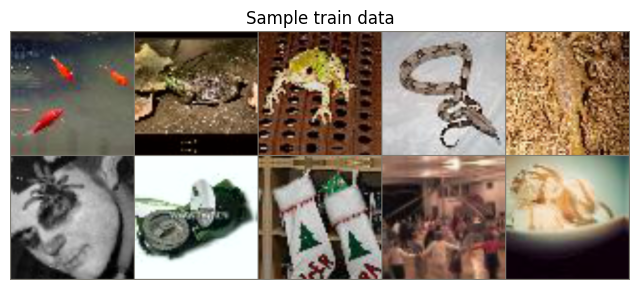

In [12]:
data = TinyImageNet(args)
data.show_samples()

In [13]:
classes_labels = data.data_labels

train_loader = data.train_loader
test_loader = data.test_loader

In [14]:
import logging
import os
from tqdm.notebook import tqdm

def check_logging_directory(path):
  parent_directory = os.path.dirname(path)
  if not os.path.exists(parent_directory):
    os.makedirs(parent_directory)
    print("Create new directory")

logging_path = './logging/tinyimagenet_omni_bayesian.log'
check_logging_directory(logging_path)

logging.basicConfig(filename=logging_path, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [15]:
kernel_num_1 = 4
kernel_num_2 = 2
od_bottleneck = 3
temperature = 50
dropout = 0.1843255380611663

learning_rate = 0.05

mb_v3 = mobilenetv3_small(num_classes = 200, od_bottleneck = od_bottleneck,
                             od_outside = 0, 
                          kernel_num_1 = kernel_num_1,
                            kernel_num_2 = kernel_num_2,
                            temperature = temperature,
                          use_od = True, drop_rate = dropout).to(args.device)

criterion = nn.CrossEntropyLoss().to(args.device)
optimizer = torch.optim.SGD(mb_v3.parameters(), lr=learning_rate,
                            weight_decay = 0.00004, momentum = 0.9)

print(f"The number of parameters: {count_parameters(mb_v3)}")

Using Normal
Using OmniDimensional
Using OmniDimensional
Using OmniDimensional
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using OD
Using Normal
Using Normal
The number of parameters: 1821123


In [16]:
def adjust_learning_rate(optimizer, epoch, total_epochs,
                         iteration, iter_per_epoch, initial_lr = 0.05):
    current_iter = iteration + epoch * iter_per_epoch
    max_iter = total_epochs * iter_per_epoch

    lr = initial_lr * (1 + np.cos(np.pi * current_iter / max_iter)) / 2

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def get_temperature(iteration, epoch, iter_per_epoch,
                        temp_epoch = 10, temp_init = 30.0):
    total_temp_iter = iter_per_epoch * temp_epoch
    current_iter = iteration + epoch * iter_per_epoch
    # print(current_iter)
    temperature = 1.0 + max(0, (temp_init - 1.0) * \
                            ((total_temp_iter - current_iter) / \
                            total_temp_iter))
    return temperature

In [17]:
from tqdm.notebook import tqdm

num_epochs = 100
# Huấn luyện mô hình
train_loss, val_loss = [], []
train_acc, val_acc = [], []

epoch_bar = tqdm(desc = 'Epoch',
                 total = num_epochs, position = 1)
train_bar = tqdm(desc = 'Training', total = len(train_loader),
                 position = 1, leave = True)
val_bar = tqdm(desc = 'Validation', total = len(test_loader),
               position = 1, leave = True)
print("🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀")


for epoch in range(num_epochs):

    epoch_bar.set_description(f'Epoch {epoch + 1}/{num_epochs}')

    mb_v3.train()
    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    for i, (X, y) in enumerate(train_loader):


        if epoch < 50:
            temp = get_temperature(i + 1, epoch, len(train_loader),
                                   temp_epoch = 50, temp_init = temperature)
            mb_v3.net_update_temperature(temp)
            print(f"The temperature is: {mb_v3.display_temperature()}")

        optimizer.zero_grad()
        X, y = X.to(args.device), y.to(args.device)

        X, y_origin, y_sampled, lam = mixup_data(X, y, args.device,
                                                 alpha = 0.2)
        
        # Forward pass
        output = mb_v3(X)
        # loss = criterion(output, y)
        loss = mixup_criterion(criterion, output, y_origin, y_sampled, lam)

        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (i + 1)
        total_loss += loss_t

        # Backward pass
        loss.backward()
        optimizer.step()

        temp_lr = adjust_learning_rate(optimizer, epoch, 100,
                                       i + 1, len(train_loader),
                                       initial_lr = learning_rate)

        # Calculating the accuracy
        _, predicted = torch.max(output.data, 1)
        n_correct = (lam * predicted.eq(y_origin.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(y_sampled.data).cpu().sum().float())
        # n_correct = (predicted == y).sum().item()
        acc_t = n_correct / len(predicted) * 100
        running_acc += (acc_t - running_acc) / (i + 1)

        total_acc += n_correct
        total += y.shape[0]

        train_bar.set_postfix(loss = running_loss,
                              acc = f"{running_acc:.2f}%",
                              epoch = epoch + 1)
        train_bar.update()

    current_loss = total_loss / len(train_loader)
    current_acc = total_acc / total * 100
    train_loss.append(current_loss)
    train_acc.append(current_acc)

    print("========================================")
    print("\033[1;34m" + f"Epoch {epoch + 1}/{num_epochs}" + "\033[0m")
    print(f"Train Loss: {current_loss:.2f}\t|\tTrain Acc: {current_acc:.2f}%")
    logging.info("========================================")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}")
    logging.info(f"Train Loss: {current_loss:.2f}")
    logging.info(f"Train Acc: {current_acc:.2f}")
    
    # Eval trên valid set
    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    mb_v3.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(test_loader):

            X, y = X.to(args.device), y.to(args.device)
            # Forward pass
            output = mb_v3(X)

            # Calculate Loss
            loss = criterion(output, y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (i + 1)
            total_loss += loss_t

            # Calculate Accuracies
            _, predicted = torch.max(output.data, 1)
            n_correct = (predicted == y).sum().item()
            acc_t = n_correct / len(predicted) * 100
            running_acc += (acc_t - running_acc) / (i + 1)
            total_acc += n_correct

            total += y.shape[0]

            val_bar.set_postfix(loss = running_loss,
                                acc = f"{running_acc:.2f}%",
                                epoch = epoch + 1)
            val_bar.update()

    current_loss = total_loss / len(test_loader)
    current_acc = total_acc / total * 100

    val_loss.append(current_loss)
    val_acc.append(current_acc)

    print(f"Val Loss: {current_loss:.2f}\t|\tVal Acc: {current_acc:.2f}%")
    logging.info(f"Val Loss: {current_loss:.2f}")
    logging.info(f"Val Acc: {current_acc:.2f}")
    
    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    if epoch < 50:
        temperature = mb_v3.display_temperature()
        print(f"The current temperature is: {temperature}")

    print(f"The current learning rate is: {temp_lr}")


print("========================================")
print("Training Completed! 😀")


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀


KeyboardInterrupt: 